In [1]:
from ultralytics import YOLO
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
import PIL.ImageFile
import ultralytics.engine.results as results
import PIL
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from importlib import reload
# from ultralytics.utils.metrics import box_iou
from scipy.optimize import linear_sum_assignment
import torch
from ultralytics.utils import ops

def plot_gt(path,ax):
    data=np.loadtxt(path.replace("images", "labels").replace("jpg","txt").replace("tif","txt")).T
    # print(data)
    cls = data[0]
    bboxes = data[1:-1].T
    z = data[-1]
    # print(bboxes)
    img = PIL.Image.open(path)
    ax.imshow(np.array(img),cmap="grey",vmin=0,vmax=2**16)
    ax.axis("off")
    for bbox,z_value in zip(bboxes,z):
        x,y,w,h = bbox*512
        rect = Rectangle((x-0.5*w,y-0.5*h),h,w, linewidth=1, edgecolor="blue", facecolor='none')
        ax.text(*rect.get_xy(),f"z={z_value:.3f}")
        ax.add_patch(rect)
    return bboxes,z


      
def match_predictions(pred_bboxes, gt_bboxes, pred_classes, true_classes,threshold):

        iou = box_iou(torch.Tensor(gt_bboxes), torch.Tensor(pred_bboxes))

        correct = np.zeros((pred_classes.shape[0])).astype(bool)
        gt_pred_matches = np.zeros((true_classes.shape[0],pred_classes.shape[0] ), dtype=bool)
        # LxD matrix where L - labels (rows), D - detections (columns)
        correct_class = true_classes[:, None] == pred_classes
        iou = iou * correct_class  # zero out the wrong classes
        iou = iou.cpu().numpy()

        cost_matrix = iou * (iou >= threshold)
        if cost_matrix.any():
            labels_idx, detections_idx = linear_sum_assignment(cost_matrix, maximize=True)
            valid = cost_matrix[labels_idx, detections_idx] > 0
            if valid.any():
                correct[detections_idx[valid]] = True
                gt_pred_matches[labels_idx,detections_idx] = valid

        return correct, gt_pred_matches
def box_iou(box1, box2, eps=1e-7):

    (a1, a2), (b1, b2) = box1.float().unsqueeze(1).chunk(2, 2), box2.float().unsqueeze(0).chunk(2, 2)
    inter = (torch.min(a2, b2) - torch.max(a1, b1)).clamp_(0).prod(2)

    # IoU = inter / (area1 + area2 - inter)
    return inter / ((a2 - a1).prod(2) + (b2 - b1).prod(2) - inter + eps)

In [2]:
# reload(results)
model = YOLO("runs/zaxis/train63/weights/best.pt")
# print(model.model.model)
print("loaded")
test_images = os.listdir("data_gen/Dataset/images/test")
random_image = lambda: "data_gen/Dataset/images/test/"+test_images[np.random.randint(0,len(test_images))]



loaded



image 1/1 /home/jupyter-till/git/ultralytics/data_gen/Dataset/images/test/image_00631.tif: 512x512 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 0.7ms postprocess per image at shape (1, 3, 512, 512)


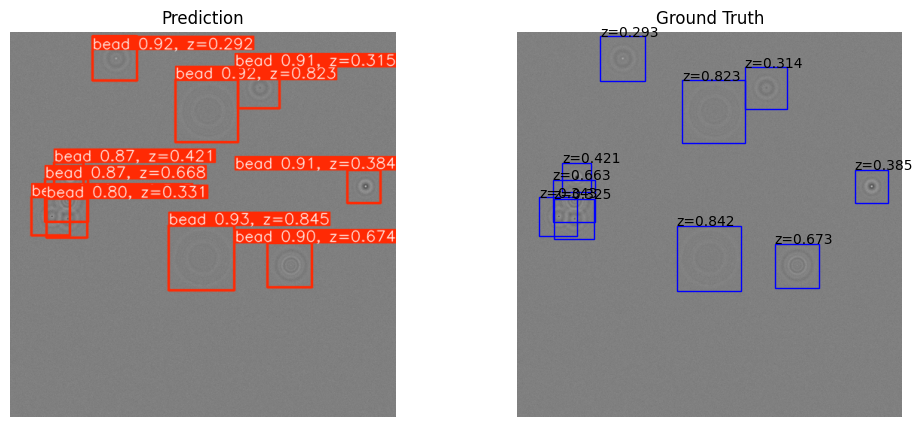

In [6]:

plt.figure(figsize=(12,5))
image = random_image()
results = model.predict(image)
res = results[0].plot()
plt.subplot(1,2,1)
plt.title("Prediction")
plt.imshow(res)
plt.axis("off")
plt.subplot(1,2,2)
plt.title("Ground Truth")

gt_bboxes,gt_z_values = plot_gt(image,plt.gca())

plt.show()

/tmp/ipykernel_880921/859206262.py:44: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  iou = iou * correct_class  # zero out the wrong classes


gt  : [    0.15826     0.18188     0.78175     0.81366     0.23293     0.77409     0.41098     0.68475     0.60689     0.66369]
yolo: [    0.15846     0.18085     0.78355     0.81471     0.23319     0.77671     0.41033     0.68662      0.6094     0.65856]
corr: [    0.15753     0.18176     0.77997     0.81186     0.67666      0.7736     0.55166     0.68176     0.60268     0.66263]


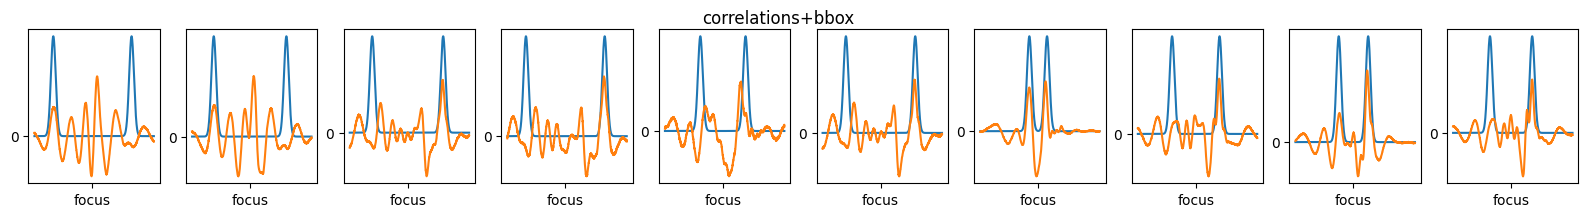

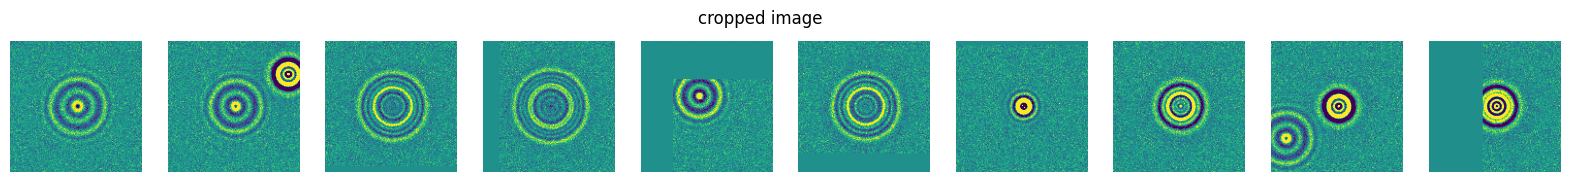

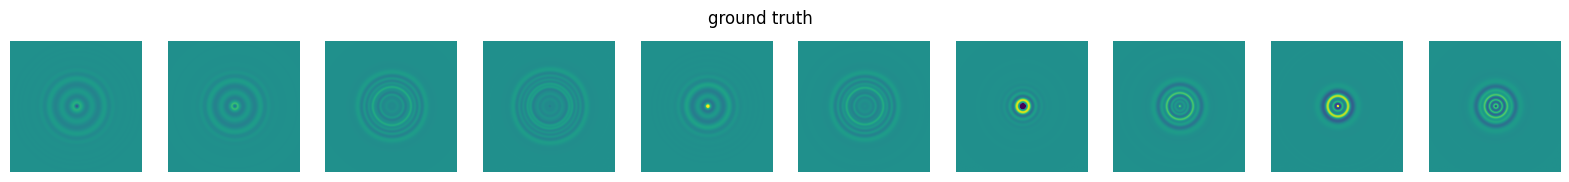

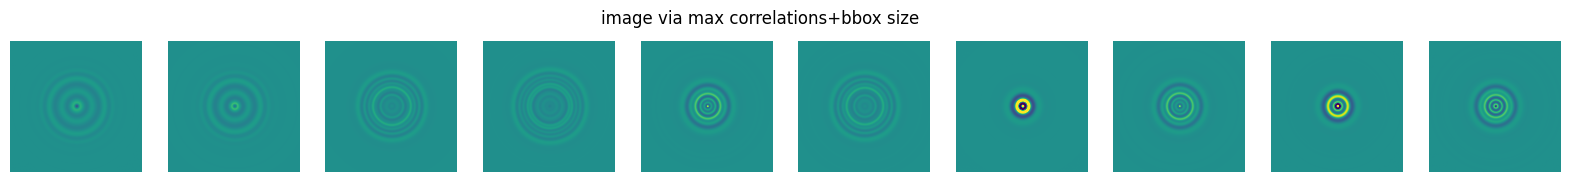

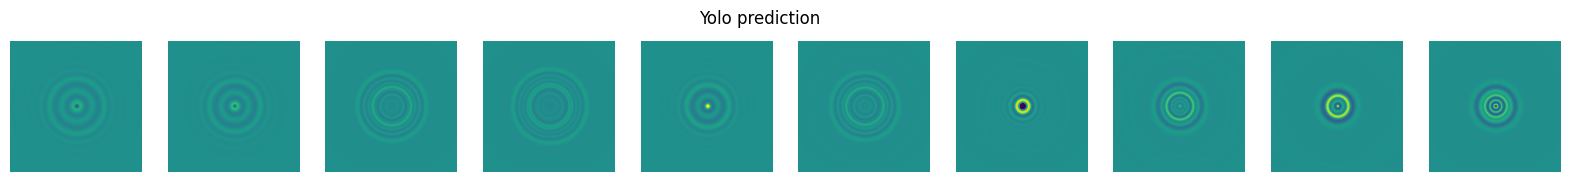

In [44]:
# plt.figure()
# plt.imshow(results[0].orig_img)
# plt.figure(figsize=(20,2))
res = results[0].zaxis.data.cpu().numpy()
padding=128
size=128
padded_image = np.pad(results[0].orig_img[...,0],padding,mode="constant",constant_values=127)

# plt.axis("off")
captures = np.empty((len(res),size,size))
for i,box in enumerate(res):
    # print(box)
    x1,y1,x2,y2,_,_,z = box
    w,h = x2-x1,y2-y1
    if(x1 == 0):
        x1-=h-w
        w = h
    if(y1 == 0):
        y1-=w-h
        h = w
    if(x2 == 511):
        x2+=h-w
        w = h
    if(y2 == 511):
        y2+=w-h
        h = w
    x,y = 0.5*(x1+x2),0.5*(y1+y2)
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    captures[i] = padded_image[y+padding-size//2:y+padding+size//2,x+padding-size//2:x+padding+size//2]
captures/=127
captures-=1
downsampled_reference = (np.load("data_gen/ripples_downsampled.npy")/10000)-2
true_bboxes = ops.xywh2xyxy(gt_bboxes) * np.array((512,512))[[1, 0, 1, 0]]  # target boxes
# ops.scale_boxes((512,512), gt_bbox, ori_shape, ratio_pad=ratio_pad)  # native-space labels
_, gt_pred_matcher = match_predictions(res[:,:4],true_bboxes,np.zeros(10),np.zeros(10),0.5)
plt.figure(figsize=(20,2))
plt.figure(figsize=(20,2))
plt.figure(figsize=(20,2))
plt.figure(figsize=(20,2))
plt.figure(figsize=(20,2))
def bells(x,w,*args):
    f = np.sum([np.exp(-(w*(x-mu)**2)) for mu in args],axis=0)
    return f/np.max(f)
x = np.arange(len(downsampled_reference))
gt_images = (downsampled_reference[np.round(gt_z_values[np.where(gt_pred_matcher.T)[1]]*len(downsampled_reference)).astype(int)])
corr = []
for i,capture in enumerate(captures):

    x1,y1,x2,y2,_,_,pred_z = res[i]
    w,h = x2-x1,y2-y1
    v = (max(w,h)*(2)-55)
    z  = (-v/0.21)+761,(v/0.21)+761
    plt.figure(1)
    plt.suptitle("correlations+bbox")
    correlation = np.pow((downsampled_reference*capture).sum(axis=(1,2)),1)
    plt.subplot(1,len(captures),i+1)
    plt.plot(bells(x,5e-4,*z)*(np.max(correlation)-np.min(correlation)))
    plt.plot(correlation)
    # plt.axvline(pred_z*len(downsampled_reference), c="red")
    plt.xticks([761],["focus"])
    plt.yticks([0])
    # plt.ylim(0,0.5)c
    # plt.tight_layout()

    plt.figure(2)
    plt.suptitle("cropped image")
    plt.subplot(1,len(captures),i+1)
    plt.imshow(capture,vmin=-0.1,vmax=0.1)
    plt.axis("off")
    # plt.tight_layout()
    plt.figure(3)
    plt.suptitle("ground truth")
    plt.subplot(1,len(captures),i+1)
    plt.imshow(gt_images[i],vmin=-0.05,vmax=0.05)
    plt.axis("off")
    plt.figure(4)
    plt.suptitle("image via max correlations+bbox size")

    plt.subplot(1,len(captures),i+1)
    plt.imshow(downsampled_reference[np.argmax(correlation*bells(x,5e-4,*z))],vmin=-0.05,vmax=0.05)
    corr.append(np.argmax(correlation*bells(x,5e-4,*z))/len(downsampled_reference))
    plt.axis("off")

    plt.figure(5)
    plt.subplot(1,len(captures),i+1)
    plt.suptitle("Yolo prediction")
    plt.imshow(downsampled_reference[np.round(pred_z*len(downsampled_reference)).astype(int)],vmin=-0.05,vmax=0.05)
    plt.axis("off")

    # plt.colorbar()

print("gt  :", gt_z_values[np.where(gt_pred_matcher.T)[1]])
print("yolo:", res[:,-1])
print("corr:", np.array(corr))
